<a href="https://colab.research.google.com/github/JeroenVanB/FruitClassification/blob/main/classify_fruit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit and vegetable classification
#### Authors
- Daan Krol (d.j.krol.1@student.rug.nl)
- Jeroen van Brandenburg (j.c.van.brandenburg@student.rug.nl)

#### Sources used
- https://www.tensorflow.org/tutorials/load_data/images
- https://www.tensorflow.org/tutorials/images/classification
- https://www.tensorflow.org/tutorials/images/transfer_learning

#### Original dataset
- https://www.kaggle.com/moltean/fruits


### Initialize global variables


In [2]:
  # 1 = MobileNetV2
  # 2 = InceptionV3
  # 3 = ResNet50
ARCHITECTURES = [x for x in range(1,4)]
USE_DATA_AUGMENTATION = False
OPTIMIZERS = ["Adam", "AdaBelief"]

###Preprocessing


In [ ]:
USING_COLAB = True
!pip install adabelief-tf==0.2.0
from adabelief_tf import AdaBeliefOptimizer
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import pathlib
import pickle
import matplotlib.pyplot as plt

In [ ]:
if USING_COLAB:
  from google.colab import drive
  drive.mount("/content/gdrive")
  !unzip '/content/gdrive/My Drive/Deep Learning/Dataset.zip'

data_dir = 'Dataset/'


In [ ]:
train_dir = pathlib.Path(data_dir + 'Train')
BATCH_SIZE = 32
IMG_SIZE = (100,100)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path(data_dir + 'Test'),
    shuffle=True,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)
num_of_classes = len(class_names)


###Visualize data

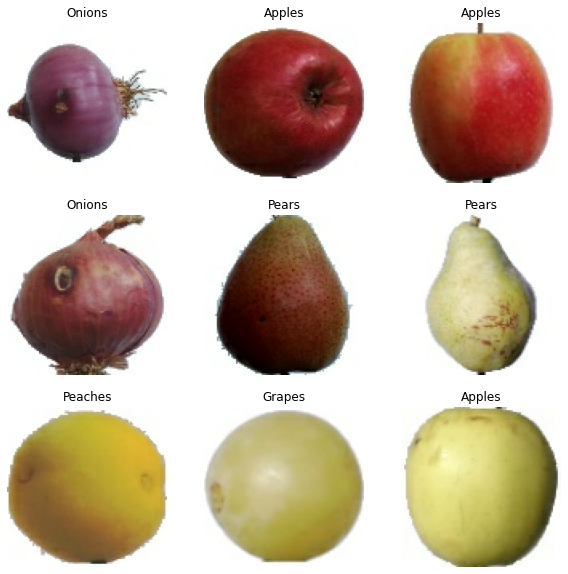

In [7]:
def plot_images():
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
plot_images()

###Data performance/caching and augmentation

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

(32, 100, 100, 3)
(32,)


In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomZoom(height_factor=(0, 0.3), fill_mode='constant', fill_value=255),
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='constant', fill_value=255),
])

### Setup and training

In [ ]:
EPOCHS = 10
IMG_SHAPE = IMG_SIZE + (3,)
results = []
data_augmentation_options = [True, False]

for arch in ARCHITECTURES:
  for opt in OPTIMIZERS:
    for use_data_augmentation in data_augmentation_options:

      if opt == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-07)
      else:
        optimizer = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-07, rectify=False)

      if arch == 1: # MobileNetV2
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
        base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')
      elif arch == 2: # Inception V3
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input
        base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')
      elif arch == 3: # ResNet50
        preprocess_input = tf.keras.applications.resnet.preprocess_input
        base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')

      # This feature extractor will convert each 100x100x3 image into a 5x5x1280 block of features
      image_batch, label_batch = next(iter(train_ds))
      feature_batch = base_model(image_batch)

      base_model.trainable = False

      global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
      feature_batch_average = global_average_layer(feature_batch)

      prediction_layer = tf.keras.layers.Dense(num_of_classes,)
      prediction_batch = prediction_layer(feature_batch_average)

      inputs = tf.keras.Input(shape=(100, 100, 3))
      x = inputs
      if use_data_augmentation:
        x = data_augmentation(inputs)
      x = preprocess_input(x)
      x = base_model(x, training=False)
      x = global_average_layer(x)
      x = tf.keras.layers.Dropout(0.2)(x)
      outputs = prediction_layer(x)
      model = tf.keras.Model(inputs, outputs)

      early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min',
                                                    restore_best_weights=True)
      model.compile(
        optimizer=optimizer,
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

      print(f'### Training with arch {arch}, opt {opt}, data_augmentation= {use_data_augmentation}')
      # Training the model
      model_history = model.fit(train_ds,
                      epochs=EPOCHS,
                      validation_data=val_ds,
                      callbacks=[early_stopping],
                      verbose=1)

      # Evaluation after training (val_ds)
      loss, accuracy = model.evaluate(test_ds)

      result = {'arch': arch, 
                'optimizer': opt, 
                'data_augmentation': use_data_augmentation, 
                'history': model_history,
                'loss': loss,
                'accuracy': accuracy}
      results.append(result)

### Learning curves plot

In [ ]:
newResults = []
for res in results:
  res['history'] = res['history'].history
  newResults.append(res)

# Save results locally
pickle.dump(newResults, open('results.p', 'wb'))

In [ ]:
# Load results
with open('results.p', 'rb') as f:
    data = pickle.load(f)

for arch in range(1,4):
    for d in data:
      if d['arch'] == arch and d['optimizer'] == 'Adam' and d['data_augmentation']:
        d_adam_data_aug = d
      if d['arch'] == arch and d['optimizer'] == 'AdaBelief' and d['data_augmentation']:
        d_adabelief_data_aug = d
      if d['arch'] == arch and d['optimizer'] == 'Adam' and not d['data_augmentation']:
        d_adam_no_data_aug = d
      if d['arch'] == arch and d['optimizer'] == 'AdaBelief' and not d['data_augmentation']:
        d_adabelief_no_data_aug = d
      
    plot_history(arch, [d_adam_data_aug, d_adabelief_data_aug, d_adam_no_data_aug, d_adabelief_no_data_aug])
    # plot_history(arch, [d_adam_no_data_aug, d_adabelief_no_data_aug])
    

In [ ]:
c1 = ['lightblue', 'lightgreen', 'salmon', 'orange']
c = ['darkblue', 'darkgreen', 'darkred', 'darkorange']
archs = ['', 'MobileNetV2', 'InceptionV3', 'ResNet50']
def plot_history(arch, data):
    print(data)
    print(arch)
    arch_name = archs[arch]

    plt.figure(figsize=(8, 8))
    # plt.subplot(2, 1, 1)
    for idx, d in enumerate(data):
      opt_name = d['optimizer']
      history = d['history']
      acc = history['accuracy']
      val_acc = history['val_accuracy']
      loss = history['loss']
      val_loss = history['val_loss'] 
      aug = ' da' if d['data_augmentation'] else ''

      plt.plot(acc, label=f'Tr. acc. {opt_name}{aug}', color=c[idx], linestyle='dotted')
      plt.plot(val_acc, label=f'Val. acc. {opt_name}{aug}', color=c[idx])
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([0.75,1])
    plt.title(f'Optimizer comparison ({arch_name})')
    plt.xlabel('epoch')
    plt.show()

### Classify fruit and vegetables

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
print(label_batch)
predictions = model.predict_on_batch(image_batch)
score = tf.nn.softmax(predictions[0])

plt.figure(figsize=(10, 10))
for i in range(9):
  score = tf.nn.softmax(predictions[i])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[np.argmax(score)] + ' ({:.2f}%)'.format(100 * np.max(score)))
  plt.axis("off")

